In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
from math import ceil
from pathlib import Path
import pickle 
from matplotlib.colors import LogNorm
import yaml
from make_waveform import BatchedLightSimulation, mod0_sampler
from tqdm import tqdm, trange

import sys
sys.path.append('/sdf/home/c/carsmith/flash_reconstruction/siren-lartpc')
sys.path.append('..')

### First, instantiate a simulator instance.

In [2]:
device = torch.device('cuda:0')

sim = BatchedLightSimulation(cfg="templates/waveform_sim.yaml").to(device)

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001
	LIGHT_WINDOW: [1, 10]


### Reconfiguring simulation properties

Default values:
```
NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
NOMINAL_TAU_S: 0.001                       # us
NOMINAL_TAU_T: 1.530                       # us
NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
```

In [3]:
params = dict()

params['singlet_fraction'] = 1.0
params['light_oscillation_period'] = 0.11
params['light_response_time'] = 0.055
params['tau_s'] = 0.001
params['tau_t'] = 1.530
params['tpb_tau'] = 0.002
params['light_gain'] = -45.0
params['light_tick_size'] = 0.0001 # 100 picoseconds in microseconds units
params['downsample_factor'] = 16

# Check it is updated
sim.reconfigure(params)
print(sim.light_tick_size)

0.0001


### Input: Load in a timing distribution from sam (from chroma)

In [4]:
'''
Importing Sam Waveform

- resolution: nanoseconds
- timing distribution: we want 100 picoseconds per time bin (10 bins per 1 nanosecond)
'''
with open("test_in_front_of_pmt_1m.pkl", "rb") as f:
    timings_in_front_of_pmt_1m = pickle.load(f) # shape (nhit) in ns
    channels_in_front_of_pmt_1m = pickle.load(f) # shape (nhit)
    position_in_front_of_pmt_1m = pickle.load(f) # [-2160, -160, -1160]
    pmt_id = pickle.load(f) # 34

# Initialize waveform of shape (num_pmts, nticks)
print(timings_in_front_of_pmt_1m.min(), timings_in_front_of_pmt_1m.max())
print(channels_in_front_of_pmt_1m.min(), channels_in_front_of_pmt_1m.max())
print("channels not 34:", channels_in_front_of_pmt_1m[channels_in_front_of_pmt_1m != 34])
print("time before 0:", timings_in_front_of_pmt_1m[timings_in_front_of_pmt_1m < 0.0])
channels_not_34 = channels_in_front_of_pmt_1m[channels_in_front_of_pmt_1m != 34]
timing_not_34 = timings_in_front_of_pmt_1m[channels_in_front_of_pmt_1m != 34]
n_pmts = channels_in_front_of_pmt_1m.max()

# Window should be 100 nanoseconds = 100 nanoseconds / 10 bins per nanosecond = 1000
n_ticks = 16000
waveform = torch.zeros((64, n_ticks))

pmt_arrival_times = torch.tensor(timings_in_front_of_pmt_1m)  # shape (nhit,), units: ns
# Convert from nanoseconds to 100 ps bins (1 ns = 10 bins)
arrival_bins = torch.clamp((pmt_arrival_times * 10).round().long(), min=0, max=n_ticks - 1) # 100 picoseconds per bin
#arrival_bins = torch.clamp((pmt_arrival_times).long(), min=0, max=n_ticks - 1) # 1 picoseconds per bin

# Accumulate hits in the waveform
print(timings_in_front_of_pmt_1m.shape[0])
print(channels_in_front_of_pmt_1m.shape[0])
print(arrival_bins.max(), arrival_bins.min())

channels = torch.tensor(channels_in_front_of_pmt_1m, dtype=torch.long)
waveform.index_put_(
    (channels, arrival_bins),
    torch.ones_like(arrival_bins, dtype=waveform.dtype),
    accumulate=True
)

wf = waveform
downsampled_wf = sim.downsample_waveform(wf.unsqueeze(0))
print(wf.shape)

# downsampled_wf = sim.downsample_waveform(wf.unsqueeze(0))
################################################################################

0.054292563 459.08475
0 63
channels not 34: [10 25 28 ... 25 42 12]
time before 0: []
325208
325208
tensor(4591) tensor(1)
torch.Size([64, 16000])


### Other input option: Use `gen_waveform` in `gaussian` mode (random arrival times)

In [5]:
# pmt_ids = torch.arange(128)
# arrival_times = torch.zeros(128, dtype=torch.int64)
# nphotons = torch.full_like(pmt_ids, 325208 / 128)
# #wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times, nphotons=1000)
# wf = sim.gen_waveform(mode='gaussian', pmt_ids=pmt_ids, nphotons=nphotons, std=1.0) # 0.05 nanoseconds
# downsampled_wf = sim.downsample_waveform(wf.unsqueeze(0))
# print(f"Waveform shape: {wf.shape}")

### Plot the Input

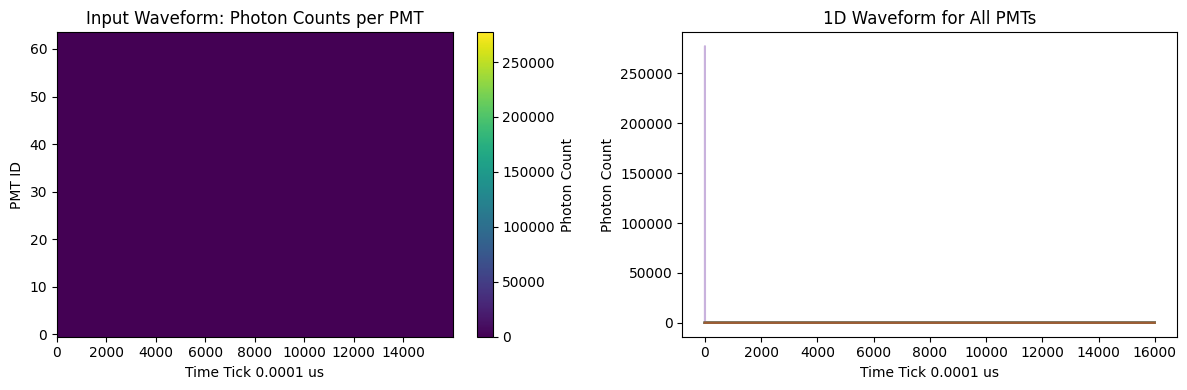

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Left plot: 2D waveform image from downsampled_wf
# im = ax1.imshow(downsampled_wf.squeeze(0), aspect='auto', origin='lower')
im = ax1.imshow(wf, aspect='auto', origin='lower')
ax1.set_xlabel(f"Time Tick {sim.light_tick_size} us")
ax1.set_ylabel("PMT ID")
ax1.set_title("Input Waveform: Photon Counts per PMT")
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Photon Count")

# Right plot: 1D waveform lines from wf
n_pmts, n_ticks = wf.shape
ticks = np.arange(n_ticks)
for i in range(n_pmts):
    ax2.plot(ticks, wf[i], alpha=0.5)
ax2.set_xlabel(f"Time Tick {sim.light_tick_size} us")
ax2.set_ylabel("Photon Count")
ax2.set_title("1D Waveform for All PMTs")

plt.tight_layout()
plt.show()

### Run simulator with stochastic scintillation & larnd-sim electronics convolution.
* Stochastic scintillation delay sampling includes prompt and delayed light with fractions specificed by configurable `sim.singlet_fraction`

`sim` forward accepts following parameters:
- `timing_dist`: input timing distribution of shape `[# in batch, # pmts, # time ticks]`
- `scintillation` (`bool`, optional): include stochastic scintillation delay (default is `True`)
- `tpb_delay` (`bool`, optional): include stochastic tpb delay (default is `False`)

In [7]:
# output, info = sim(wf.to(device), tpb_delay=False, combined=False)
# output = output.detach().cpu().numpy()
# print(f"Output shape: {output.shape}")

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# # 2D timing histogram
# im = ax1.imshow(output, aspect='auto', origin='lower')
# ax1.set_xlabel("Time Tick")
# ax1.set_ylabel("PMT ID")
# ax1.set_title("Output Waveform")

# cbar = fig.colorbar(im, ax=ax1)
# cbar.set_label("Output Signal [ADC]")

# # 1D waveform per pmt
# ticks = np.arange(output.shape[1])
# for i in range(n_pmts):
#     ax2.plot(ticks, output[i], marker = 'o', markersize=4, alpha=0.5, label=i)
# ax2.set_xlabel("Time Tick")
# ax2.set_ylabel("Output Signal [ADC]")
# ax2.set_title("1D Waveform for All PMTs")
# plt.tight_layout()
# plt.show()

### Simulate with a time delay from the TPB wavelength shifter
This delay is sampled from an exponential re-emission timing distribution with a lifetime of 2 nanoseconds.

In [8]:
# # Using same input as before: 100 photons per pmt
# output, info = sim(wf.to(device), tpb_delay=True, combined=False)
# output = output.detach().cpu().numpy()
# print(f"Output shape: {output.shape}")

# ############### Plotting ############################
# fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 row, 2 columns
# ax1, ax2, ax3, ax4 = axs.flatten()

# # Left plot: 2D waveform image  
# im = ax1.imshow(downsampled_wf.squeeze(0), aspect='auto', origin='lower')
# ax1.set_xlabel("Time Tick")
# ax1.set_ylabel("PMT ID")
# ax1.set_title("Input Waveform: Photon Counts per PMT")
# cbar = fig.colorbar(im, ax=ax1)
# cbar.set_label("Photon Count")

# # Right plot: 1D waveform lines
# n_pmts, n_ticks = wf.shape
# ticks = np.arange(n_ticks)
# for i in range(n_pmts):
#     ax2.plot(ticks, wf[i], marker='o', markersize=4, alpha=0.5)
# ax2.set_xlabel("Time Tick")
# ax2.set_ylabel("Photon Count")
# ax2.set_title("1D Waveform for All PMTs")

# # Bottm left: 2D timing histogram
# im = ax3.imshow(output, aspect='auto', origin='lower')
# ax3.set_xlabel("Time Tick")
# ax3.set_ylabel("PMT ID")
# ax3.set_title("Output Waveform")

# cbar = fig.colorbar(im, ax=ax3)
# cbar.set_label("Output Signal [ADC]")

# # Bottom right: 1D line plot
# ticks = np.arange(output.shape[1])
# for i in range(n_pmts):
#     ax4.plot(ticks, output[i], marker = 'o', markersize=4, alpha=0.5, label=i)
# ax4.set_xlabel("Time Tick")
# ax4.set_ylabel("Output Signal [ADC]")
# ax4.set_title("1D Waveform for All PMTs")
# plt.tight_layout()
# plt.show()

In [9]:
pwd

'/sdf/home/c/carsmith/flash_reconstruction/waveforms'

### Finally, simulating with vectorized & combined scintillation and tpb sampling for fastest version.

total combined sampling time: 0.0160 sec
sipm response conv. time: 0.0007 sec
forward time: 0.0183 sec
Output shape: (64, 16000)


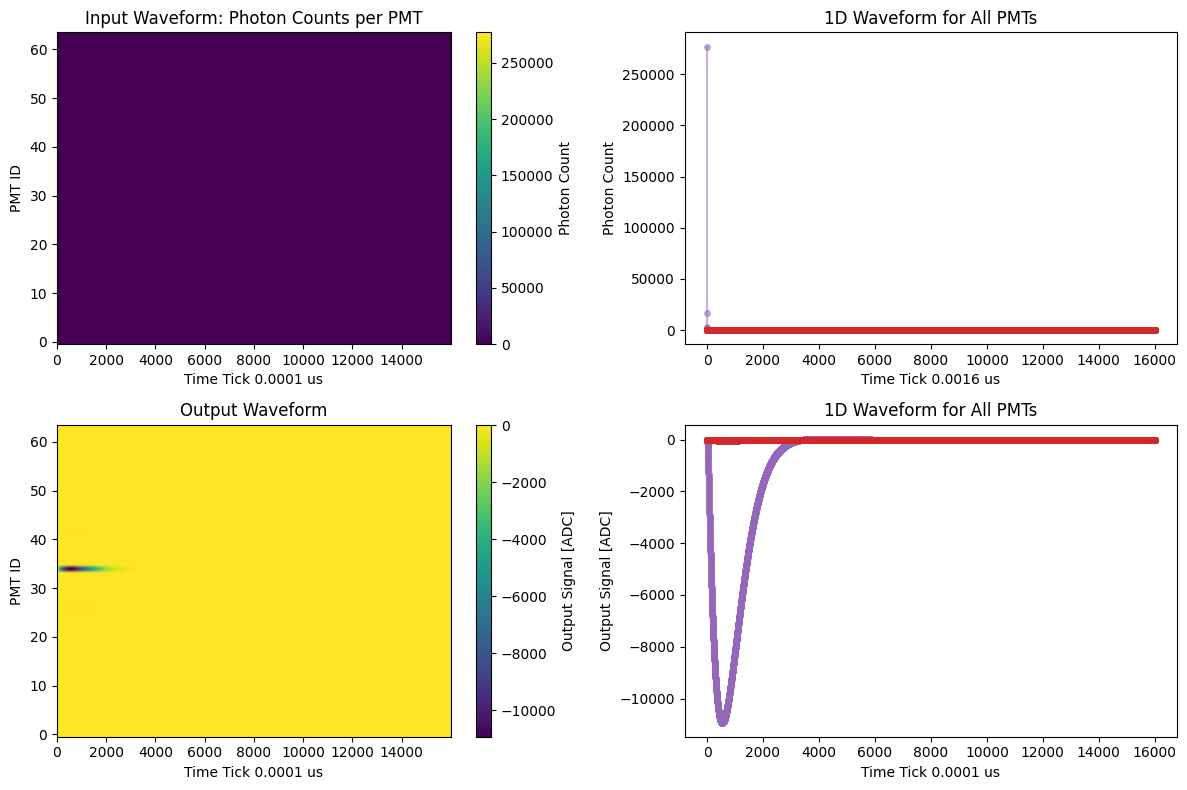

In [15]:
output, info = sim(wf.to(device), combined=True)
output = output.detach().cpu().numpy()
print(f"Output shape: {output.shape}")

############### Plotting ############################
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 row, 2 columns
ax1, ax2, ax3, ax4 = axs.flatten()

# Left plot: 2D waveform image  
im = ax1.imshow(wf, aspect='auto', origin='lower')
ax1.set_xlabel(f"Time Tick {sim.light_tick_size} us")
ax1.set_ylabel("PMT ID")
ax1.set_title("Input Waveform: Photon Counts per PMT")
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Photon Count")

# Right plot: 1D waveform lines
# n_pmts, n_ticks = downsampled_wf.squeeze(0).shape
n_pmts, n_ticks = wf.shape
ticks = np.arange(n_ticks)
for i in range(n_pmts):
    ax2.plot(ticks, wf[i], marker='o', markersize=4, alpha=0.5)
ax2.set_xlabel(f"Time Tick {sim.light_tick_size * sim.downsample_factor} us")
ax2.set_ylabel("Photon Count")
ax2.set_title("1D Waveform for All PMTs")

# Bottm left: 2D timing histogram
im = ax3.imshow(output, aspect='auto', origin='lower')
ax3.set_xlabel(f"Time Tick {sim.light_tick_size} us")
ax3.set_ylabel("PMT ID")
ax3.set_title("Output Waveform")

cbar = fig.colorbar(im, ax=ax3)
cbar.set_label("Output Signal [ADC]")

# Bottom right: 1D line plot
ticks = np.arange(output.shape[1])
for i in range(n_pmts):
    ax4.plot(ticks, output[i], marker = 'o', markersize=4, alpha=0.5, label=i)
ax4.set_xlabel(f"Time Tick {sim.light_tick_size} us")
ax4.set_ylabel("Output Signal [ADC]")
ax4.set_title("1D Waveform for All PMTs")
plt.tight_layout()
plt.show()

### Plotting the expected & sampled photons from the scintillation and tpb delay distributions.

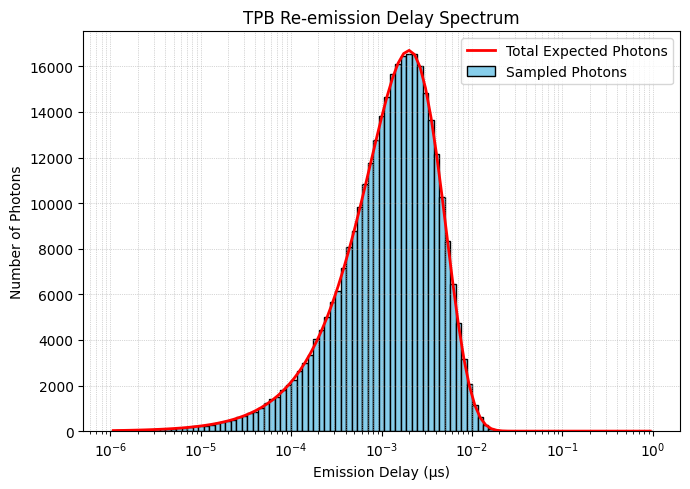

In [14]:
tpb_tau = 0.002  # 2 nanoseconds

bins = np.geomspace(1e-6, 1e0, 100)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_widths = bins[1:] - bins[:-1]

emission_delays = info['tpb_emission_delays']

hist, _ = np.histogram(emission_delays, bins=bins)

photons_arrived = info['num_singlets'] + info['num_triplets']

# expected exponential PDF evaluated at bin centers
pdf = (1 / tpb_tau) * np.exp(-bin_centers / tpb_tau)

# expected number of photons per bin by integrating (PDF × bin width)
expected = pdf * bin_widths
expected_scaled = expected / expected.sum() * photons_arrived

# plotting
plt.figure(figsize=(7, 5))
plt.bar(bin_centers, hist, width=bin_widths, color='skyblue', edgecolor='black', align='center', label='Sampled Photons')
plt.plot(bin_centers, expected_scaled, color='red', lw=2, label='Total Expected Photons')

plt.xscale('log')
plt.xlabel('Emission Delay (μs)')
plt.ylabel('Number of Photons')
plt.title('TPB Re-emission Delay Spectrum')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

Photons Arrived: 325208


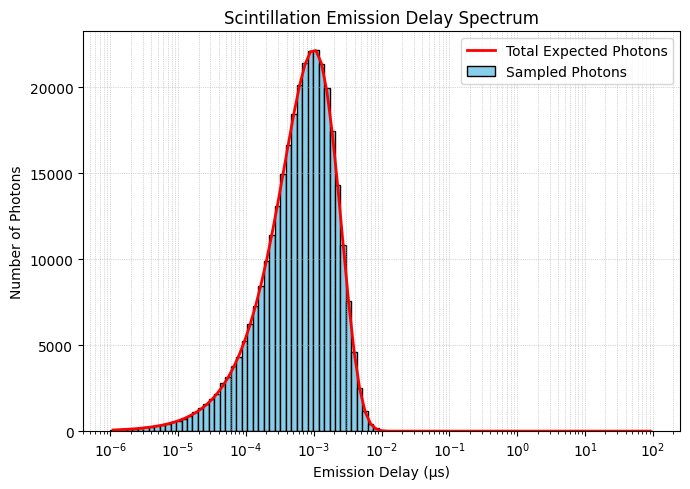

In [12]:
# Scintillation delay histogram
tau_s = sim.tau_s
tau_t = sim.tau_t
singlet_frac = sim.singlet_fraction
triplet_frac = 1 - singlet_frac

# Define bins
emission_delays = info['scintillation_delays']

bins = np.geomspace(1e-6, 1e2, 100)
hist, bin_edges = np.histogram(emission_delays, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_widths = bin_edges[1:] - bin_edges[:-1]

# calculating n_photons that reached pmt
photons_arrived = info['num_singlets'] + info['num_triplets']
print(f"Photons Arrived: {photons_arrived}")

# Compute scaled theoretical PDFs
pdf_s = (1 / tau_s) * np.exp(-bin_centers / tau_s)
pdf_t = (1 / tau_t) * np.exp(-bin_centers / tau_t)
pdf_s_scaled = pdf_s * singlet_frac * photons_arrived * bin_widths
pdf_t_scaled = pdf_t * triplet_frac * photons_arrived * bin_widths
total_scaled = pdf_s_scaled + pdf_t_scaled

# Plot
plt.figure(figsize=(7, 5))
plt.bar(bin_centers, hist, width=bin_widths, color='skyblue', edgecolor='black', align='center', label='Sampled Photons')
plt.plot(bin_centers, total_scaled, color='red', lw=2, label='Total Expected Photons')

plt.xscale('log')
plt.xlabel('Emission Delay (μs)')
plt.ylabel('Number of Photons')
plt.title('Scintillation Emission Delay Spectrum')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

### Checking that waveform starts at 0 + offset (no photons before original arrival time)

In [13]:
# Checking that waveform starts exactly at 0 (+ some offset)
print(output.shape)

# from make_waveform.py
offset = 2560 # nanoseconds
downsample_factor = 16

mask = output< -0.001
selected_values = output[mask]
masked_output = output.copy()  # avoid modifying original
masked_output[~(output < -0.001)] = 0

print("signal starts at tick: ", np.argmax(masked_output != 0))
print("it should start at tick: ", np.argmax(wf !=0) / downsample_factor)

(64, 16000)
signal starts at tick:  126
it should start at tick:  tensor(6.7500)
